In [1]:
import nengo
import numpy as np
import scipy.special as sp
import matplotlib.pyplot as plt
import scipy.stats as st
from nengo.spa import Vocabulary
from nengo.dists import UniformHypersphere

num_neurons = 50
x = 60
dim = max_age = 120
thetas = np.linspace(start=1, stop=max_age, num=max_age)   # all possible values of theta (from 1 to 120)
p_theta = [(st.skewnorm.pdf(p, a=-4, loc=97, scale=28)) for p in thetas]  # prior probability: p(theta)
p_theta = p_theta/np.sum(p_theta)    # normalize prior (to sum up to 1)
p_theta = [100*a for a in p_theta]
likelihood = [100*1/p for p in thetas]  #  p(X/theta)

#likelihood = [1/p for p in thetas]  #  p(X/theta)
likelihood[0:x-1] = [0]*(x-1)
 
rng = np.random.RandomState(12) 
model = nengo.Network()
num_samples = 4000*5
with model:
  
    prior_in = nengo.Node(output=p_theta)
    likelihood_in = nengo.Node(output=likelihood)
    
    # define eval points to only represent positive values
    encoders = UniformHypersphere(surface=True).sample(num_neurons, 1, rng=rng)
    eval_points = rng.uniform(0, 1, size=(num_samples, 1))
    
    prior = nengo.networks.EnsembleArray(n_neurons=num_neurons, n_ensembles=dim, 
                            radius=3, encoders=encoders, eval_points=eval_points, 
                            n_eval_points=eval_points.shape[0]) 
    likelihood = nengo.networks.EnsembleArray(n_neurons=num_neurons, n_ensembles=dim, 
                            radius=3, encoders=encoders, eval_points=eval_points, 
                            n_eval_points=eval_points.shape[0])
    posterior = nengo.networks.EnsembleArray(n_neurons=num_neurons, n_ensembles=dim, 
                            radius=3, encoders=encoders, eval_points=eval_points, 
                            n_eval_points=eval_points.shape[0])

    nengo.Connection(prior_in, prior.input)
    nengo.Connection(likelihood_in, likelihood.input)   
    
    product = nengo.networks.Product(n_neurons=num_neurons*2, dimensions=dim, input_magnitude=3)
    
    nengo.Connection(likelihood.output, product.A)
    nengo.Connection(prior.output, product.B)
    nengo.Connection(product.output, posterior.input)

       
    def normalization(t, a):
        total = np.sum(a)
        if total == 0:
            return 0
        return a / total
    
    def median(t, b):
        med = 0
        for n in np.arange(len(b)):
            cum = sum(b[:n+1])
            if cum == 0.5 or cum > 0.5:
                med = n + 1
                break
        return med
        
    
    def multiply(c):
        a = c[:dim]
        b = c[dim]
        if b == 0:
            return [0]*120
        out = a / b
        return out
    
    # use the nodes to do the computation
    norm_post = nengo.Node(normalization, size_in=dim, size_out=dim)
    prediction = nengo.Node(median, size_in=dim, size_out=1) 
    nengo.Connection(posterior.output, norm_post)
    nengo.Connection(norm_post, prediction)
    
    norm = nengo.Ensemble(n_neurons=num_neurons, dimensions=1, radius=2, 
                          encoders=encoders, eval_points=eval_points, 
                            n_eval_points=eval_points.shape[0])
    scale = nengo.networks.EnsembleArray(n_neurons=num_neurons, n_ensembles=dim, 
                            radius=1, encoders=encoders, eval_points=eval_points, 
                            n_eval_points=eval_points.shape[0])
    post_final = nengo.networks.EnsembleArray(n_neurons=num_neurons, n_ensembles=dim, 
                            radius=1, encoders=encoders, eval_points=eval_points, 
                            n_eval_points=eval_points.shape[0])
    
    # define encoders and eval points for 121 dimensions
    encoders = UniformHypersphere(surface=True).sample(num_neurons*(dim+1), dim+1, rng=rng)
    eval_points = rng.uniform(0, 1, size=(num_samples, dim+1))
    intermediate = nengo.Ensemble(n_neurons=num_neurons*(dim+1), dimensions=dim+1, 
                            radius=1, encoders=encoders, eval_points=eval_points, 
                            n_eval_points=eval_points.shape[0])
    nengo.Connection(posterior.output, scale.input, transform=10, synapse=0.1)   # scale posterior
    nengo.Connection(scale.output, norm, transform=np.ones((1,120)), synapse=0.1)     # compute the sum of posterior
    nengo.Connection(scale.output, intermediate[:dim], synapse=0.1)
    nengo.Connection(norm, intermediate[dim], synapse=0.1)
    nengo.Connection(intermediate, post_final.input, function=multiply, synapse=0.1)
    
        
    bg = nengo.networks.BasalGanglia(dimensions=dim)
    nengo.Connection(posterior.output, bg.input)
    thal = nengo.networks.Thalamus(dimensions=dim)
    nengo.Connection(bg.output, thal.input, synapse=0.01)
    

In [2]:
with model:
    posterior_p = nengo.Probe(posterior.output, synapse=0.03)
    prior_p = nengo.Probe(prior.output, synapse=0.03)
    likelihood_p = nengo.Probe(likelihood.output, synapse=0.03)
    bg_p = nengo.Probe(bg.output, synapse=0.03)
    thal_p = nengo.Probe(thal.output, synapse=0.03)
    norm_post_p = nengo.Probe(norm_post, synapse=0.03)
    prediction_p = nengo.Probe(prediction, synapse=0.03)
    
    norm_p = nengo.Probe(norm, synapse=0.03)
    scale_p = nengo.Probe(scale.output, synapse=0.03)
    intermediate_p = nengo.Probe(intermediate, synapse=0.03)
    post_final_p = nengo.Probe(post_final.output, synapse=0.03)
    

In [3]:
sim = nengo.Simulator(model)  # Create the simulator
sim.run(1.0)                  # Run it for 1.0 seconds

Building finished in 0:02:58.                                                   
Simulating finished in 0:02:04.                                                 


MAP:  72
Prediction:  [ 78.95050738]


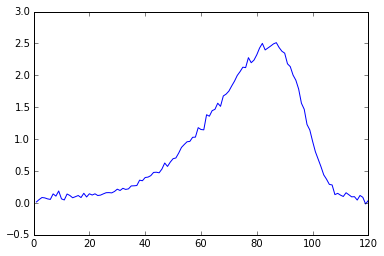

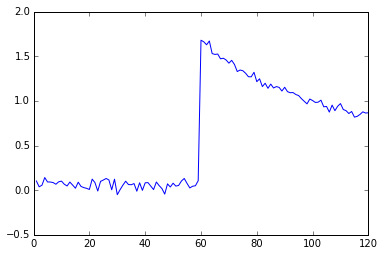

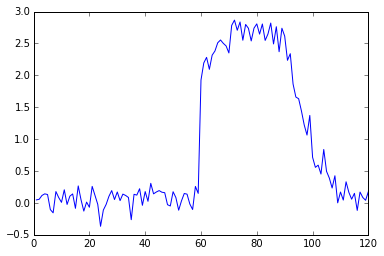

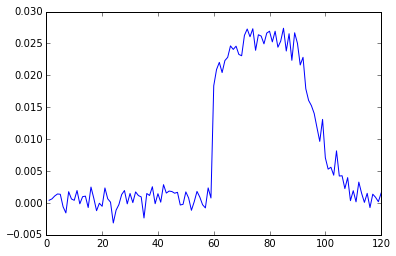

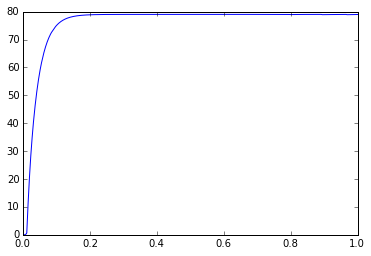

In [25]:
% matplotlib inline
plt.figure()
prior = sim.data[prior_p]
plt.plot(thetas, prior[len(prior)-10])

plt.figure()
likelihood = sim.data[likelihood_p]
plt.plot(thetas, likelihood[len(likelihood)-10])

plt.figure()
posterior = sim.data[posterior_p]
plt.plot(thetas, posterior[len(posterior)-10])
print "MAP: ", np.argmax(posterior[len(posterior)-10]) + 1

plt.figure()
norm_post = sim.data[norm_post_p]
plt.plot(thetas, norm_post[len(norm_post)-10])

plt.figure()
prediction = sim.data[prediction_p]
print "Prediction: ", prediction[len(prediction)-10]
plt.plot(sim.trange(), prediction)



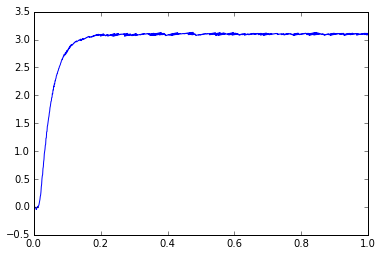

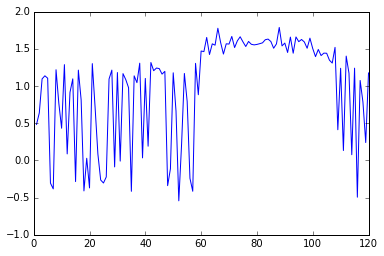

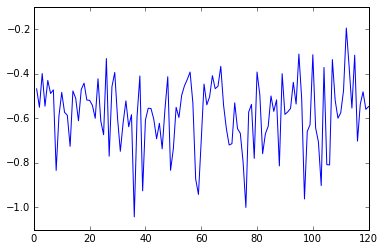

In [7]:
plt.figure()
norm = sim.data[norm_p]
plt.plot(sim.trange(), norm)

plt.figure()
scale = sim.data[scale_p]
plt.plot(thetas, scale[len(scale)-10])

plt.figure()
post_final = sim.data[post_final_p]
plt.plot(thetas, post_final[len(post_final)-10])

In [8]:
np.set_printoptions(threshold=500000)
posterior = sim.data[posterior_p]

#print posterior[len(posterior)-50]

#prior = sim.data[prior_p]
#print prior[len(prior)-50]

[-7.4445454  -7.48223453 -7.40651317 -7.37219369 -7.41829359 -7.4012226
 -7.68903771 -7.48948694 -7.46723648 -7.59650615 -7.44464597 -7.34830082
 -7.77218267 -7.37870924 -7.35211786 -7.46728685 -7.40943742 -7.47027805
 -7.57324056 -7.48590935 -7.19902105 -7.44415292 -7.60852673 -7.58306736
 -7.29879671 -7.57748539 -7.50883487 -7.50663755 -7.84611904 -7.56809832
 -7.52814066 -7.41128956 -7.60934896 -7.5339022  -7.484438   -7.43755978
 -7.46514074 -7.36302839 -7.61727394 -7.51078076 -7.61547802 -7.29626379
 -7.56687372 -7.58807651 -7.40231487 -7.47267516 -7.44890223 -7.37226063
 -7.37928423 -7.42576382 -7.26473598 -7.5571732  -7.50901419 -7.65114174
 -7.79234355 -7.8791187  -7.45812418 -7.53438157 -7.45448859 -7.30597399
 -7.38615174 -7.55860402 -7.33480011 -7.43858638 -7.36921715 -7.21408514
 -7.36931808 -7.39703859 -7.26429289 -7.42897139 -7.45586577 -7.38783943
 -7.24881531 -7.45561991 -7.42810608 -7.51691677 -7.39980852 -7.50180572
 -7.2765759  -7.26468352 -7.28076847 -7.49434025 -7.

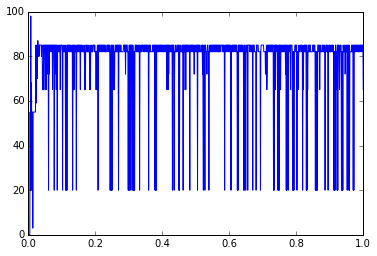

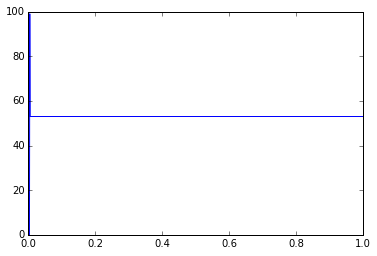

In [18]:
% matplotlib inline
plt.figure()
plt.plot(sim.trange(), sim.data[bg_p].argmax(axis=1))

plt.figure()
plt.plot(sim.trange(), sim.data[thal_p].argmax(axis=1))

thal = sim.data[thal_p]
test = thal[len(thal)-10]

bg = sim.data[bg_p]
test = bg[len(bg)-10]

print test
print np.argmax(test)

In [52]:
a = [1,2,3,4,5]
print a[:4]

[1, 2, 3, 4]
